In [1]:
from osgeo import ogr, gdal, osr
from pygeotools.lib import malib, warplib, geolib, iolib, timelib
import os
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import glob
import driveanon

In [2]:
# define glacier shapefile
glac_shp_fn = 'GlacOutline/OLYGlac_Output.shp'

In [3]:
# shapefile properties and layers
# save the shapefile with multiple features going forward
glac_shp_ds = ogr.Open(glac_shp_fn,0)
glac_shp_lyr = glac_shp_ds.GetLayer()
glac_shp_srs = glac_shp_lyr.GetSpatialRef()
feat_count = glac_shp_lyr.GetFeatureCount()
print("Input glacier polygon count: %i" % feat_count)

Input glacier polygon count: 1011


In [5]:
#files = driveanon.list_blobs('1Tdq2LA4UV5S5HTL8oBzhoRry1V1wK6nk',
#                             '.tif',
#                            )
#for f in files:
#    driveanon.save(f,overwrite=True)
    
fname = glob.glob('*tif')

In [6]:
# read in the defined raster and warp to common spatial references (will need to change fnList indices)
# Note: surface z1 is always taken as the reference surface
gdal.Warp('z1_proj.tif',fname[1],dstSRS='EPSG:26910')
gdal.Warp('z2_proj.tif',fname[2],dstSRS='EPSG:26910')
z1_ds = gdal.Open('z1_proj.tif')
z2_ds = gdal.Open('z2_proj.tif')

In [7]:
# determing the overlappinge extents of the rasters
dz_int_geom = geolib.ds_geom_intersection([z1_ds,z2_ds],\
                                         t_srs=glac_shp_srs)

In [8]:
# filter shapefile features for new extent
glac_shp_lyr.SetSpatialFilter(dz_int_geom)
feat_count = glac_shp_lyr.GetFeatureCount()
print("Glacier polygon count after spatial filter: %i" % feat_count)

Glacier polygon count after spatial filter: 536


In [9]:
# prep for warping
ra_dict = OrderedDict()
ra_dict['z1'] = z1_ds
ra_dict['z2'] = z2_ds
aea_srs = glac_shp_srs

In [10]:
# instantiate the glacier class
# glacier mass-balance function (work in progress)
class GlacFeat:
    def __init__(self,feat):
        self.z1 = None
        self.z2 = None
        self.dz = None
        self.glac_geom_orig = geolib.geom_dup(feat.GetGeometryRef())
        self.glac_geom = geolib.geom_dup(self.glac_geom_orig)
        self.glac_geom_extent = geolib.geom_extent(self.glac_geom)
        
def massbal(gf,ra_dict,aea_srs,Un):
    # warp to extent of shapefile feature
    warp_extent = geolib.pad_extent(gf.glac_geom_extent,width=100) 
    ds_list = warplib.memwarp_multi(ra_dict.values(),res='min',\
                                    extent=warp_extent,t_srs=aea_srs,\
                                    r='cubic')
    
    # ouput/mask numpy arrays
    gf.z1 = np.array(ds_list[0].GetRasterBand(1).ReadAsArray())
    gf.z1 = np.ma.masked_less_equal(gf.z1,0.0)
    gf.z2 = np.array(ds_list[1].GetRasterBand(1).ReadAsArray())
    gf.z2 = np.ma.masked_less_equal(gf.z2,0.0)
    # determine surface change
    gf.dz = gf.z1-gf.z2
    
    # mask based on glacier extents
    glac_shp_lyr_mask = geolib.lyr2mask(Un,ds_list[0])
    gf.dz = np.ma.array(gf.dz,mask=glac_shp_lyr_mask) 
    
    # filter based on previous knowledge
    # WILL NEED TO COME BACK AND CHANGE
    gf.dz = np.ma.masked_less(gf.dz,-15)
    gf.dz = np.ma.masked_greater(gf.dz,15)
    
    # filter based on 90% confidence interval
    rangelim = malib.calcperc(gf.dz, (5,95))
    gf.dz = np.ma.masked_outside(gf.dz, *rangelim)
        

In [11]:
# read in single-feature glacier shapefile
glacUn = ogr.Open('GlacOutline/Merged/OLYGlac_Output.shp',0)
glacUn_lyr = glacUn.GetLayer()

In [12]:
# iterator
cnt = 0
mb_dict = OrderedDict()
z1_dict = OrderedDict()
z2_dict = OrderedDict()

# for each glacier feature of given size, run mass-balance function and save outputs
for n, feat in enumerate(glac_shp_lyr):
    if feat.Area_1 > 1.0:
        gf = GlacFeat(feat)
        massbal(gf,ra_dict,aea_srs,glacUn_lyr)
        print(feat.Name_1)
        mb_dict[cnt] = gf.dz
        z1_dict[cnt] = gf.z1
        z2_dict[cnt] = gf.z2
    
        cnt += 1


Warping all inputs to the following:
Resolution: 7.999999999998002
Extent: [447408.1957, 5292053.9792, 451070.0285, 5295362.6033]
Projection: '+proj=utm +zone=10 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs '
Resampling alg: cubic

1 of 2: z1_proj.tif
nl: 414 ns: 458 res: 8.000
2 of 2: z2_proj.tif
nl: 414 ns: 458 res: 8.000
Hoh

Warping all inputs to the following:
Resolution: 7.999999999998002
Extent: [445974.4702, 5293790.5668, 449280.1325, 5297419.9827]
Projection: '+proj=utm +zone=10 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs '
Resampling alg: cubic

1 of 2: z1_proj.tif
nl: 454 ns: 413 res: 8.000
2 of 2: z2_proj.tif
nl: 454 ns: 413 res: 8.000
Blue

Warping all inputs to the following:
Resolution: 7.999999999998002
Extent: [450087.2973, 5292400.1454, 452441.9236, 5293707.6732]
Projection: '+proj=utm +zone=10 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs '
Resampling alg: cubic

1 of 2: z1_proj.tif
nl: 163 ns: 294 res: 8.000
2 of 2: z2_proj.tif
nl: 163 ns

Text(0.5, 0, '458 meters')

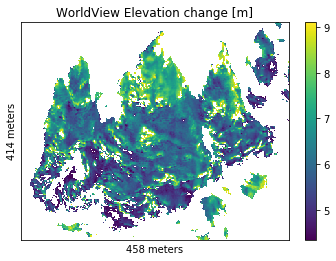

In [13]:
# plotting
plt.imshow(mb_dict[3])
plt.colorbar()
plt.title('WorldView Elevation change [m]')
plt.xticks([])
plt.yticks([])
plt.ylabel(str(len(z1_dict[0]))+' meters')
plt.xlabel(str(len(z1_dict[0][0]))+' meters')